Notebook executed in collab - GPU, with reduced dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import modules
import tensorflow as tf
import tensorflow.keras as K

from tensorflow.keras.applications import VGG16

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

import numpy as np
import librosa.display, os
import keras.utils as image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow_hub as hub
import datetime
import matplotlib.pyplot as plt

In [3]:
# For XAI
import lime
from skimage.segmentation import mark_boundaries

from tensorflow import keras
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.utils import load_img, img_to_array
import requests
from skimage.segmentation import slic
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import shap
import warnings

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [5]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''

    image, mask = exp.get_image_and_mask(exp_class,
                                         positive_only=show_positive,
                                         num_features=6,
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    %matplotlib inline
    plt.imshow(mark_boundaries(image, mask))
    plt.plot()

In [6]:
# Load data parameters
tf.random.set_seed(42)

batch_size = 32
img_height = img_width = 224
channels = 3
epochs = 20
input_shape = (224, 224, 3)

root_train = '/content/drive/MyDrive/spectrograms/training' #r'path_to_Spectrogram_folder'
root_test = '/content/drive/MyDrive/spectrograms/testing' #r'path_to_Spectrogram_folder'

In [7]:
train_ds = K.utils.image_dataset_from_directory(str(root_train),
                                               validation_split = 0.2,
                                               subset = 'training',
                                               seed = 42,
                                               image_size = (img_height, img_width),
                                               batch_size = batch_size)

test_ds = K.utils.image_dataset_from_directory(str(root_test),
                                               validation_split = 0.2,
                                               subset = 'validation',
                                               seed = 42,
                                               image_size = (img_height, img_width),
                                               batch_size = batch_size)

Found 13631 files belonging to 2 classes.
Using 10905 files for training.
Found 564 files belonging to 2 classes.
Using 112 files for validation.


In [8]:
class_names = np.array(train_ds.class_names)
print(class_names)

['fake' 'real']


In [9]:
total_train_samples = len(train_ds)
steps_per_epoch = tf.math.ceil(total_train_samples / batch_size)

In [10]:
total_val_samples = len(test_ds)
validation_steps = tf.math.ceil(total_val_samples / batch_size)

# VGG16

In [12]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
for layer in vgg16.layers:
    layer.trainable = False

In [14]:
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [15]:
model_vgg = Model(inputs=vgg16.input, outputs=x)

In [16]:
model_vgg.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])

In [22]:
history_vgg16 = model_vgg.fit(train_ds, epochs=30,
                    steps_per_epoch=int(steps_per_epoch),
                    validation_data=test_ds,
                    validation_steps=int(validation_steps))

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 98s 7s/step - accuracy: 0.5248 - loss: 3.7970 - val_accuracy: 0.1250 - val_loss: 5.0623
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 77s 8s/step - accuracy: 0.6612 - loss: 2.4641 - val_accuracy: 0.2188 - val_loss: 4.7092
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 85s 8s/step - accuracy: 0.6970 - loss: 2.0441 - val_accuracy: 0.3438 - val_loss: 3.8217
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 85s 8s/step - accuracy: 0.7551 - loss: 1.6464 - val_accuracy: 0.4375 - val_loss: 3.5633
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 85s 8s/step - accuracy: 0.7779 - loss: 1.3165 - val_accuracy: 0.4062 - val_loss: 4.0640
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 84s 8s/step - accuracy: 0.8013 - loss: 1.6167 - val_accuracy: 0.3438 - val_loss: 3.4524
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.8150 - loss: 1.2557 - val_accuracy: 0.2812 - val_loss: 4.6759
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.7963 - loss: 1.2810 - val_accuracy: 0.4062 - val_loss:

In [23]:
loss, accuracy = model_vgg.evaluate(test_ds)
print('Validation accuracy:', accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7301 - loss: 1.1002
Validation accuracy: 0.7053571343421936


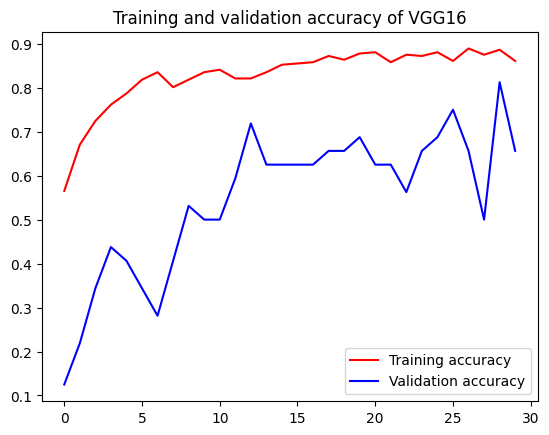

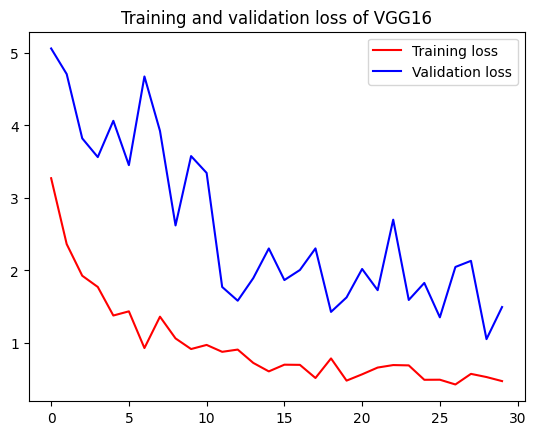

In [24]:
acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy of VGG16')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of VGG16')
plt.legend()

plt.show()

In [28]:
model_vgg.save('/content/drive/MyDrive/models/audio/my_vgg16.h5')

In [29]:
model_vgg.save('/content/drive/MyDrive/models/audio/my_vgg16.keras')

In [ ]:
model_vgg.export('/content/drive/MyDrive/models/audio/vgg16')

# Custom CNN

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_cnn.add(MaxPooling2D(2, 2))

model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(2, 2))

model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(2, 2))

model_cnn.add(Flatten())

model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(tf.keras.layers.Dropout(0.3))

model_cnn.add(Dense(512, activation = 'relu'))
model_cnn.add(tf.keras.layers.Dropout(0.3))

model_cnn.add(Dense(1, activation='softmax'))

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

log_dir = "logs/fit/" + "cnn-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq = 1)

model_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,751,489 (170.71 MB)

 Trainable params: 44,751,489 (170.71 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history4 = model_cnn.fit(train_ds,
                    validation_data = test_ds,
                    epochs = 20,
                    callbacks = tensorboard_callback)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.5074 - loss: 16.3282

Not enough RAM to go further...

In [ ]:
# Plot accuracy curve
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of Custom CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Plot loss curve
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Loss')
plt.plot(epochs, val_acc, ':', label='Validation Loss')
plt.title('Training and Validation Loss of Custom CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_cnn.save('/content/drive/MyDrive/models/audio/my_cnn.h5')

In [ ]:
model_cnn.save('/content/drive/MyDrive/models/audio/my_cnn.keras')

In [ ]:
model_cnn.export('/content/drive/MyDrive/models/audio/cnn')

# RESNET

In [30]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import keras

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height, img_width, channels))

# Do not train the model, leverage pretrained layers
for layer in resnet.layers:
    layer.trainable = False

resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [31]:
# Create transfer learning model

model_resnet = Sequential()

# Add pretrained model as it is
model_resnet.add(resnet)
# Flatten last layer of resnet
model_resnet.add(Flatten())
# Add layers of our own
model_resnet.add(Dense(512, activation='relu', input_dim=(img_height, img_width, channels)))
model_resnet.add(tf.keras.layers.Dropout(0.3))
model_resnet.add(Dense(512, activation='relu'))
model_resnet.add(tf.keras.layers.Dropout(0.3))
model_resnet.add(Dense(1, activation='sigmoid'))

model_resnet.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,231,617 (286.99 MB)

 Trainable params: 51,643,905 (197.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [32]:
model_resnet.compile(loss='binary_crossentropy',
                     optimizer=keras.optimizers.RMSprop(learning_rate = 2e-5),
                     metrics=['accuracy'])

log_dir = "logs/fit/" + "resnet-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq = 1)

In [ ]:
history3 = model_resnet.fit(train_ds,
                    validation_data = test_ds,
                    epochs = 20,
                    callbacks = tensorboard_callback)

Epoch 1/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.8778 - loss: 0.3205

Not enough RAM to go further.

In [ ]:
# Plot accuracy curve
acc = history3.history['acc']
val_acc = history3.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Plot loss curve
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Loss')
plt.plot(epochs, val_acc, ':', label='Validation Loss')
plt.title('Training and Validation Loss of ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_resnet.save('/content/drive/MyDrive/models/audio/my_resnet.h5')

In [ ]:
model_resnet.save('/content/drive/MyDrive/models/audio/my_resnet.keras')

In [ ]:
model_resnet.export('/content/drive/MyDrive/models/audio/resnet')